## 3. Modling -- Multiple Class Prediction on Reddit Submission Topics

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import spacy
import gensim
from gensim import corpora, models
import pyLDAvis.gensim_models


### Pre-processing with SpaCy

In [10]:
# Load data
file_path_text_clean = "data/processed-data/text_clean.csv"
df = pd.read_csv(file_path_text_clean)

# Additional domain-specific stopwords
domain_stopwords = {
    'trump', 'biden', 'republican', 'democrat', 'like', 'im', 'dont', 'people',
    'think', 'know', 'would', 'said', 'one', 'year', 'state', 'time'
}

# Load SpaCy model for better text processing
nlp = spacy.load('en_core_web_sm')

def improved_text_preprocessing(text):
    # Handle non-string inputs
    if not isinstance(text, str):
        if pd.isna(text):  
            return ""
        text = str(text)  
    
    doc = nlp(text)
    # Keep only nouns, adjectives, verbs, and adverbs
    tokens = [token.lemma_.lower() for token in doc 
             if (token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']) 
             and (token.lemma_.lower() not in domain_stopwords)
             and (len(token.lemma_) > 2)]
    return ' '.join(tokens)

# Convert text column to string type and handle NaN values
df['text'] = df['text'].fillna("").astype(str)

df['text'] = df['text'].apply(improved_text_preprocessing)
submissions = df[df['type'].str.contains('submission')].copy()

### NMF Topic Modeling

In [11]:
def perform_nmf_analysis(texts, n_topics=5):
    """Perform NMF topic modeling"""
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2)
    )
    tfidf = tfidf_vectorizer.fit_transform(texts)
    
    nmf_model = NMF(
        n_components=n_topics,
        random_state=42
    )
    nmf_topics = nmf_model.fit_transform(tfidf)
    
    return np.argmax(nmf_topics, axis=1), nmf_model, tfidf_vectorizer


### DBSCAN Clustering Modeling

In [12]:
def perform_dbscan_validation(texts, tfidf_vectorizer):
    print("\nPerforming DBSCAN validation...")
    
    # Create TF-IDF vectors
    tfidf = tfidf_vectorizer.transform(texts)
    
    # Scale the features
    scaler = StandardScaler(with_mean=False)
    scaled_tfidf = scaler.fit_transform(tfidf)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_tfidf)
    
    # Count number of clusters found
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"DBSCAN found {n_clusters} clusters")
    print(f"Number of samples in each cluster: {pd.Series(dbscan_labels).value_counts().sort_index()}")
    
    # K-distance plot (distance to the 5th nearest neighbor)
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_tfidf)
    distances, indices = neigh.kneighbors(scaled_tfidf)
    
    # Plot k-distance graph (distances to 5th nearest neighbor)
    distances = np.sort(distances[:, -1], axis=0)
    plt.plot(distances)
    plt.title('k-distance plot')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to 5th nearest neighbor')
    plt.show()
    
    return dbscan_labels

### LDA Topic Modeling

In [13]:
# def perform_lda_analysis(texts, n_topics=5):
#     # Create dictionary and corpus
#     texts_tokenized = [text.split() for text in texts]
#     dictionary = corpora.Dictionary(texts_tokenized)
#     corpus = [dictionary.doc2bow(text) for text in texts_tokenized]
    
#     # Train LDA model
#     lda_model = models.LdaModel(
#         corpus,
#         num_topics=n_topics,
#         id2word=dictionary,
#         passes=15,
#         random_state=42
#     )
    
#     # Create visualization
#     vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
#     pyLDAvis.save_html(vis_data, 'lda_visualization.html')
    
#     # Get topic assignments
#     topic_assignments = []
#     for doc in corpus:
#         topics = lda_model.get_document_topics(doc)
#         main_topic = max(topics, key=lambda x: x[1])[0]
#         topic_assignments.append(main_topic)
        
#     return topic_assignments, lda_model

### Results

Performing topic analysis...

NMF Topics:
Topic 0: say, abortion, feel, get, want, right, make, woman, even, life
Topic 1: gun, rifle, reddit, gun owner, owner, assault, assault rifle, law, health, couple
Topic 2: tax, pay, pay tax, work, income, system, low, call, federal, amount
Topic 3: climate, change, climate change, call, point, news, article, insurance, meat, help
Topic 4: vote, election, conservative, end, communist, worker, last, voting, socialist, democratic

Performing DBSCAN validation...
DBSCAN found 1 clusters
Number of samples in each cluster: -1    648
 0     29
Name: count, dtype: int64


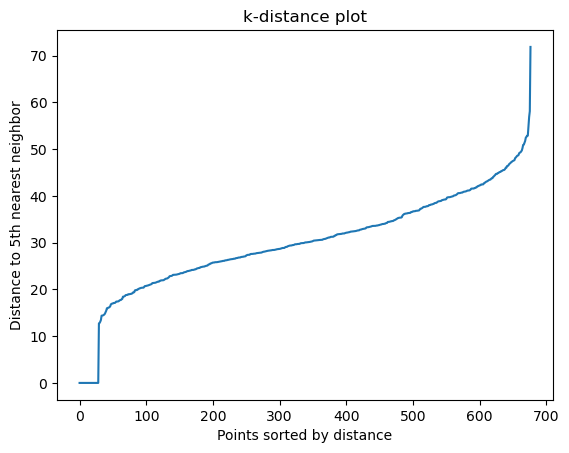


Comparison of NMF topics and DBSCAN clusters:
dbscan_cluster   -1   0
nmf_topic              
0               427  29
1                61   0
2                45   0
3                52   0
4                63   0


In [14]:
# Apply all methods
print("Performing topic analysis...")

# # 1. LDA Analysis
# lda_topics, lda_model = perform_lda_analysis(submissions['text'])
# submissions['lda_topic'] = lda_topics
# print("\nLDA Topics:")
# for idx in range(lda_model.num_topics):
#     print(f"Topic {idx}:", end=' ')
#     terms = lda_model.show_topic(idx, 10)
#     print(', '.join([term for term, _ in terms]))

# 2. NMF Analysis -- best
nmf_topics, nmf_model, tfidf_vectorizer = perform_nmf_analysis(submissions['text'])
submissions['nmf_topic'] = nmf_topics
# Function to display top terms for each topic
def display_top_terms(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        print(f"Topic {topic_idx}: {', '.join(top_terms)}")

# Display results
print("\nNMF Topics:")
display_top_terms(nmf_model, tfidf_vectorizer.get_feature_names_out())

# 3. DBSCAN Clustering
submissions['dbscan_cluster'] = perform_dbscan_validation(submissions['text'], tfidf_vectorizer)

# Compare NMF and DBSCAN results
print("\nComparison of NMF topics and DBSCAN clusters:")
print(pd.crosstab(submissions['nmf_topic'], submissions['dbscan_cluster']))


### Assigning Topics

In [15]:
# Create simplified topic labels (select the top term)
topic_labels = {
    0: "abortion",  
    1: "guns",      
    2: "tax",       
    3: "climate",   
    4: "politics"   
}

# Add topic labels to submissions
submissions['nmf_topic'] = submissions['nmf_topic'].map(topic_labels)


# Create a new column 'nmf_topic' to store the topic label for each row
df['nmf_topic'] = None

# Variables to store the current submission ID and its topic
current_submission_id = None
current_topic = None

# Iterate through the dataset and assign the topic of the parent submission to each comment
for idx, row in df.iterrows():
    if 'submission' in row['type']:  # If the current row is a submission
        # Get the current submission's ID and its topic
        current_submission_id = row['id']
        current_topic = submissions[submissions['id'] == current_submission_id]['nmf_topic'].values
        if current_topic.size > 0:
            current_topic = current_topic[0]
        df.at[idx, 'nmf_topic'] = current_topic  
    # If the row is a comment, assign the parent submission's topic
    if 'comment' in row['type'] and current_submission_id is not None:
        df.at[idx, 'nmf_topic'] = current_topic

In [16]:
# Save results
df_text_topic = df

file_path_text_topic = "data/processed-data/text_topic.csv"
df_text_topic.to_csv(file_path_text_topic, index=False)

print(f"\nModeling complete. Results saved to {file_path_text_topic}")
df_text_topic.head(6)

# Display sample results
print("\nSample results:")
df_text_topic.head(6)


Modeling complete. Results saved to data/processed-data/text_topic.csv

Sample results:


,subreddit,id,type,depth,score,time,text,nmf_topic
0,Libertarian,1hf706u,submission_hot,0,100,2024/12,road serfdom new libertarian economic let borr...,abortion
1,Libertarian,m29svuv,comment,1,1,2024/12,fredrich bastiat also good actually make funct...,abortion
2,Libertarian,m2a5co6,comment,2,1,2024/12,libertarian exclusively anarchist,abortion
3,Libertarian,m2a694w,comment,3,1,2024/12,true socialist communist always say fix ideolo...,abortion
4,Libertarian,m29bopi,comment,1,7,2024/12,good favorite always recommend start revolutio...,abortion
5,Libertarian,m2a1cm0,comment,1,1,2024/12,salma write book become movie star,abortion
